<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_01_2_intro_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# stained Biopsy Image vs Preprocessed Histogram Equilized image

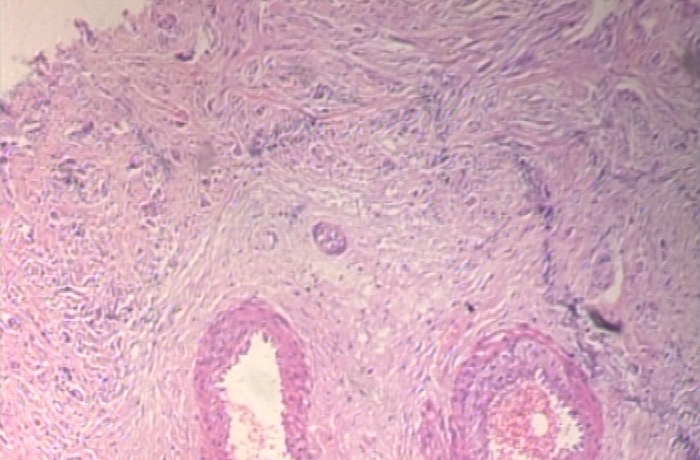

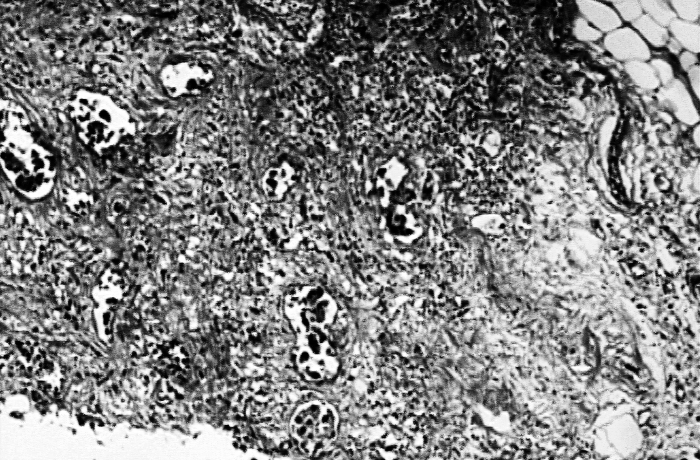

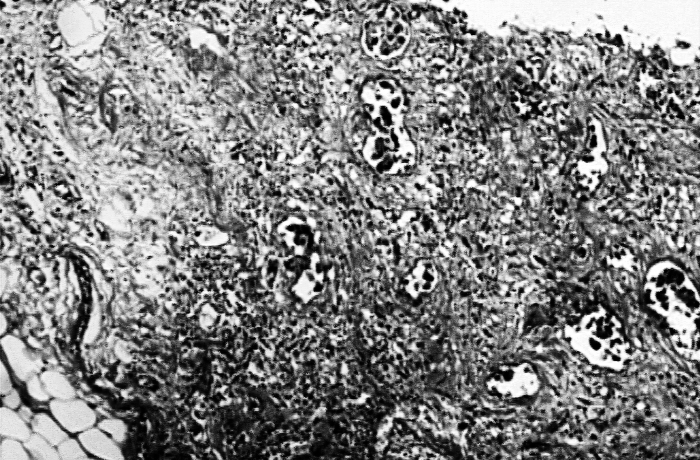

Stained Image: 

![hello](img/Histopathology1.png)

# Breast Cancer Dataset from:
https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

#### *Dataset intro

i) dataset is impalance, malignant vs benign 

ii) images come in multiple resolutions 40X, 100X, 200X, 400X from 82 patients:

    Training patients: 40 Mal, 17 Ben

    Testing patients: 18 Mal, 07 Ben

    imbalanced data, Mal samples are more than 150% of Ben images


iii) higher resolution images from the same slide

iv) image augmentation techniques used to balance the data including 180(deg) rotation and side flip

v) remove stain from images using cv2.equalizeHist

vi) (460, 700) original images. further augmentation by croping the images

vii) use UVA google drive account to store images

In [0]:
from google.colab import drive 
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
import pdb 
from tqdm.notebook import tqdm 
from os import listdir  
import matplotlib.pyplot as plt 
from PIL import Image   
import PIL 
import cv2 
import numpy as np 
import tarfile
import shutil
from distutils.dir_util import copy_tree
import pandas as pd
import torch
import torch.nn.functional as F

## 0) Data Preprocessing

In all the other attempts I had made a mistake not to split data patient wise

In [0]:
#### Unpack the 40, 100, 200, and 400 folders

# Opening the already saved training and testing folders saved in googledrive

orig_path="./drive/My Drive/Python 3"

os.listdir(orig_path)

['BreaKHis_v1.tar.gz',
 '.ipynb_checkpoints',
 'Wrong data no based on Patients',
 'Breast_processed.tar.gz',
 'Training_SET',
 'Testing_SET',
 'EH_40X',
 'EH_400X',
 'EH_200X',
 'EH_100X',
 'EH_Balanced_40X.tar.gz',
 'EH_Balanced_100X.tar.gz',
 'EH_Balanced_200X.tar.gz',
 'EH_Balanced_400X.tar.gz',
 'model-Resnet-34-40X-1578176704.log',
 'model-Resnet-34-40X-1578176983.log',
 'model-Resnet-34-40X-1578182806.log',
 'model-Resnet-34-100X-1578193177.log',
 'Model_400_Res34',
 'Model_200_Res34',
 'Model_40_Res34',
 'model-Resnet-34-100X-1578344055.log',
 'Model_100_Res34',
 'model-Inception_v3-40X-1578861638.log',
 'model-Inception_v3-40X-1578862827.log',
 'model-Inception_v3-40X-1578862939.log',
 'model-Resnet-18-modified-40X-1579401387.log']

In [0]:
# 0: Benign,  1: Malignant

PATH={   0 : 'BreaKHis_v1/histology_slides/breast/benign/SOB'
       , 1 : 'BreaKHis_v1/histology_slides/breast/malignant/SOB'} 

In [0]:
os.mkdir('./drive/My Drive/Python 3/Ben')
os.mkdir('./drive/My Drive/Python 3/Mal') 

In [0]:
copy_tree( PATH[0] , os.path.join(orig_path,'Ben') )

copy_tree( PATH[1] , os.path.join(orig_path,'Mal') )

In [0]:
#### 

# Opening the already saved training and testing folders saved in googledrive

path="./drive/My Drive/Python 3/"

os.listdir(path)

['BreaKHis_v1.tar.gz',
 '.ipynb_checkpoints',
 'Wrong data no based on Patients',
 'Breast_processed.tar.gz',
 'Training_SET',
 'Testing_SET',
 'Training_EH_40X',
 'Testing_EH_40X']

In [0]:
#### 

# Opening the already saved training and testing folders saved in googledrive

path="./drive/My Drive/Python 3/Training_SET/Ben"

print(os.listdir(path))

path="./drive/My Drive/Python 3/Training_SET/Ben/SOB_B_TA_14-16184"

os.listdir(path)

['SOB_B_TA_14-16184', 'SOB_B_TA_14-3411F', 'SOB_B_TA_14-13200', 'SOB_B_TA_14-15275', 'SOB_B_TA_14-16184CD', 'SOB_B_F_14-14134E', 'SOB_B_F_14-9133', 'SOB_B_F_14-21998CD', 'SOB_B_F_14-23060CD', 'SOB_B_F_14-25197', 'SOB_B_F_14-14134', 'SOB_B_PT_14-21998AB', 'SOB_B_PT_14-29315EF', 'SOB_B_A_14-22549AB', 'SOB_B_A_14-29960CD', 'SOB_B_A_14-22549G', 'SOB_B_A_14-22549CD']


['100X', '40X', '200X', '400X']

#### 0.1) * Remove stain from images by Histogram Equalization 

https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/histogram_equalization/histogram_equalization.html

In [0]:
def EH_process(From_forlder,To_forlder):
    for ii in os.listdir(From_forlder):
        #print(ii,'EH_Gray_'+ii)
        img = cv2.imread(os.path.join(From_forlder,ii))
        img = cv2.equalizeHist( cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) )
        #cv2_imshow(img)
        cv2.imwrite( os.path.join(To_forlder,'EH_Gray_'+ii) , img )

### Training set

## 40X/Ben: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Training_SET/Ben"

To_forlder = "./drive/My Drive/Python 3/Training_EH_40X/Ben"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'40X')
    EH_process(FF,To_forlder) 

## 40X/Mal: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Training_SET/Mal"

To_forlder = "./drive/My Drive/Python 3/Training_EH_40X/Mal"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'40X')
    EH_process(FF,To_forlder) 

### Testing set

## 40X/Ben: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Testing_SET/Ben"

To_forlder = "./drive/My Drive/Python 3/Testing_EH_40X/Ben"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'40X')
    EH_process(FF,To_forlder) 

## 40X/Mal: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Testing_SET/Mal"

To_forlder = "./drive/My Drive/Python 3/Testing_EH_40X/Mal"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'40X')
    EH_process(FF,To_forlder) 

In [0]:
### Training set

## 100X/Ben: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Training_SET/Ben"

To_forlder = "./drive/My Drive/Python 3/Training_EH_100X/Ben"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'100X')
    EH_process(FF,To_forlder) 

## 100X/Mal: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Training_SET/Mal"

To_forlder = "./drive/My Drive/Python 3/Training_EH_100X/Mal"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'100X')
    EH_process(FF,To_forlder) 

### Testing set

## 100X/Ben: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Testing_SET/Ben"

To_forlder = "./drive/My Drive/Python 3/Testing_EH_100X/Ben"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'100X')
    EH_process(FF,To_forlder) 

## 100X/Mal: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Testing_SET/Mal"

To_forlder = "./drive/My Drive/Python 3/Testing_EH_100X/Mal"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'100X')
    EH_process(FF,To_forlder) 

In [0]:
### Training set

## 200X/Ben: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Training_SET/Ben"

To_forlder = "./drive/My Drive/Python 3/Training_EH_200X/Ben"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'200X')
    EH_process(FF,To_forlder) 

## 200X/Mal: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Training_SET/Mal"

To_forlder = "./drive/My Drive/Python 3/Training_EH_200X/Mal"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'200X')
    EH_process(FF,To_forlder) 

### Testing set

## 200X/Ben: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Testing_SET/Ben"

To_forlder = "./drive/My Drive/Python 3/Testing_EH_200X/Ben"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'200X')
    EH_process(FF,To_forlder) 

## 200X/Mal: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Testing_SET/Mal"

To_forlder = "./drive/My Drive/Python 3/Testing_EH_200X/Mal"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'200X')
    EH_process(FF,To_forlder) 

In [0]:
### Training set

## 400X/Ben: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Training_SET/Ben"

To_forlder = "./drive/My Drive/Python 3/Training_EH_400X/Ben"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'400X')
    EH_process(FF,To_forlder) 

## 400X/Mal: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Training_SET/Mal"

To_forlder = "./drive/My Drive/Python 3/Training_EH_400X/Mal"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'400X')
    EH_process(FF,To_forlder) 

### Testing set

## 400X/Ben: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Testing_SET/Ben"

To_forlder = "./drive/My Drive/Python 3/Testing_EH_400X/Ben"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'400X')
    EH_process(FF,To_forlder) 

## 400X/Mal: Copy EH photos to training and testing forlders

From_forlder = "./drive/My Drive/Python 3/Testing_SET/Mal"

To_forlder = "./drive/My Drive/Python 3/Testing_EH_400X/Mal"

for ii in os.listdir(From_forlder):
    FF=os.path.join(From_forlder,ii,'400X')
    EH_process(FF,To_forlder) 

In [0]:
# creating histogram equalized image folders

def make_tarfile(output_filename , source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir)

make_tarfile('./drive/My Drive/Python 3/EH_Balanced_40X.tar.gz','./drive/My Drive/Python 3/EH_40X')
make_tarfile('./drive/My Drive/Python 3/EH_Balanced_100X.tar.gz','./drive/My Drive/Python 3/EH_100X')
make_tarfile('./drive/My Drive/Python 3/EH_Balanced_200X.tar.gz','./drive/My Drive/Python 3/EH_200X')
make_tarfile('./drive/My Drive/Python 3/EH_Balanced_400X.tar.gz','./drive/My Drive/Python 3/EH_400X')

In [0]:
shutil.rmtree(To_forlder)

## 1) Data Copying from google drive

In [0]:
from google.colab import drive 
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#### Unpack the 40, 100, 200, and 400 folders

# Opening the already saved training and testing folders saved in googledrive

orig_path="./drive/My Drive/Python 3"

os.listdir(orig_path)

['BreaKHis_v1.tar.gz',
 '.ipynb_checkpoints',
 'Wrong data no based on Patients',
 'Breast_processed.tar.gz',
 'Training_SET',
 'Testing_SET',
 'EH_40X',
 'EH_400X',
 'EH_200X',
 'EH_100X',
 'EH_Balanced_40X.tar.gz',
 'EH_Balanced_100X.tar.gz',
 'EH_Balanced_200X.tar.gz',
 'EH_Balanced_400X.tar.gz',
 'model-Resnet-34-40X-1578176704.log',
 'model-Resnet-34-40X-1578176983.log',
 'model-Resnet-34-40X-1578182806.log',
 'model-Resnet-34-100X-1578193177.log',
 'Model_400_Res34',
 'Model_200_Res34',
 'Model_40_Res34',
 'model-Resnet-34-100X-1578344055.log',
 'Model_100_Res34',
 'model-Inception_v3-40X-1578861638.log',
 'model-Inception_v3-40X-1578862827.log',
 'model-Inception_v3-40X-1578862939.log',
 'model-Resnet-18-modified-40X-1579401387.log']

### i) Gray scale images

In [0]:
EH_40X= "./drive/My Drive/Python 3/EH_40X.tar.gz"

with tarfile.open(EH_40X,'r') as TAR:
     TAR.extractall('./') 

In [0]:
EH_100X= "./drive/My Drive/Python 3/EH_100X.tar.gz"

with tarfile.open(EH_100X,'r') as TAR:
     TAR.extractall('') 

#### i.1) *image augmentation by 180 degree rotation and side flip

In [0]:
def process(image_path, degrees_to_rotate, saved_location_1, saved_location_2,ij,ji):
    """
    Rotate the given photo the amount of given degreesk, show it and save it
 
    @param image_path: The path to the image to edit
    @param degrees_to_rotate: The number of degrees to rotate the image
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    
    if ij == 0:
          process_image = image_obj.rotate(180)
          if ji == 2:
              process_image_2 = image_obj.transpose(Image.FLIP_LEFT_RIGHT) 
              process_image_2.save(saved_location_2)
    else:
          process_image = image_obj.transpose(Image.FLIP_LEFT_RIGHT) 
          if ji == 2:
              process_image_2 = image_obj.rotate(180)
              process_image_2.save(saved_location_2)
    #print(ij,ji)
    #image_obj.show()
    #process_image.show()
    process_image.save(saved_location_1)

In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_40X/Training_EH_40X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_40X/Training_EH_40X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Mal')))


932 913
477 457


In [0]:
# image augmentation 

pathh = './drive/My Drive/Python 3/EH_40X/Training_EH_40X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct = image_obj.rotate(180) 
    pct.save(os.path.join(pathh,'ALT_'+img))

In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_40X/Training_EH_40X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_40X/Training_EH_40X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Mal')))


932 913
159 457


In [0]:
# image augmentation 

pathh = './drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct1 = image_obj.rotate(180) 
    pct1.save(os.path.join(pathh,'ALT_180_'+img))
    pct2 = image_obj.transpose(Image.FLIP_LEFT_RIGHT)
    pct2.save(os.path.join(pathh,'ALT_Flip_'+img))
    

In [0]:
image_obj.size

(700, 460)

In [0]:
# image augmentation 

pathh = './drive/My Drive/Python 3/EH_40X/Training_EH_40X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct = image_obj.rotate(180) 
    break

In [0]:
pct2

In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_40X/Training_EH_40X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_40X/Training_EH_40X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Mal')))


932 913
477 457


In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_100X/Training_EH_100X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_100X/Training_EH_100X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_100X/Testing_EH_100X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_100X/Testing_EH_100X/Mal')))


485 998
159 439


In [0]:
# image augmentation 

pathh = './drive/My Drive/Python 3/EH_100X/Training_EH_100X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct = image_obj.rotate(180) 
    pct.save(os.path.join(pathh,'ALT_'+img))

In [0]:
# image augmentation 

pathh = './drive/My Drive/Python 3/EH_100X/Testing_EH_100X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct1 = image_obj.rotate(180) 
    pct1.save(os.path.join(pathh,'ALT_180_'+img))
    pct2 = image_obj.transpose(Image.FLIP_LEFT_RIGHT)
    pct2.save(os.path.join(pathh,'ALT_Flip_'+img))
 

In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_100X/Training_EH_100X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_100X/Training_EH_100X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_100X/Testing_EH_100X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_100X/Testing_EH_100X/Mal'))) 

970 998
477 439


In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_200X/Training_EH_200X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_200X/Training_EH_200X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_200X/Testing_EH_200X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_200X/Testing_EH_200X/Mal'))) 

466 969
157 421


In [0]:
# image augmentation 

pathh = './drive/My Drive/Python 3/EH_200X/Training_EH_200X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct = image_obj.rotate(180) 
    pct.save(os.path.join(pathh,'ALT_'+img))

# image augmentation 

pathh = './drive/My Drive/Python 3/EH_200X/Testing_EH_200X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct1 = image_obj.rotate(180) 
    pct1.save(os.path.join(pathh,'ALT_180_'+img))
    pct2 = image_obj.transpose(Image.FLIP_LEFT_RIGHT)
    pct2.save(os.path.join(pathh,'ALT_Flip_'+img))

In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_200X/Training_EH_200X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_200X/Training_EH_200X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_200X/Testing_EH_200X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_200X/Testing_EH_200X/Mal'))) 

932 969
471 421


In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_400X/Training_EH_400X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_400X/Training_EH_400X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_400X/Testing_EH_400X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_400X/Testing_EH_400X/Mal')))  

438 842
150 390


In [0]:
# image augmentation 

pathh = './drive/My Drive/Python 3/EH_400X/Training_EH_400X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct = image_obj.rotate(180) 
    pct.save(os.path.join(pathh,'ALT_'+img))

# image augmentation 

pathh = './drive/My Drive/Python 3/EH_400X/Testing_EH_400X/Ben'

for img in os.listdir(pathh):
    image_path = os.path.join(pathh,img)
    image_obj = Image.open(image_path)
    pct1 = image_obj.rotate(180) 
    pct1.save(os.path.join(pathh,'ALT_180_'+img))
    pct2 = image_obj.transpose(Image.FLIP_LEFT_RIGHT)
    pct2.save(os.path.join(pathh,'ALT_Flip_'+img))
 

In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_400X/Training_EH_400X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_400X/Training_EH_400X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_400X/Testing_EH_400X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_400X/Testing_EH_400X/Mal')))  

876 842
450 390


#### i.2) * Balanced Gray scaled EH image in test and train folders

In [0]:
print( len(os.listdir('./drive/My Drive/Python 3/EH_40X/Training_EH_40X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_40X/Training_EH_40X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_40X/Testing_EH_40X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_100X/Training_EH_100X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_100X/Training_EH_100X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_100X/Testing_EH_100X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_100X/Testing_EH_100X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_200X/Training_EH_200X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_200X/Training_EH_200X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_200X/Testing_EH_200X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_200X/Testing_EH_200X/Mal')))  

print( len(os.listdir('./drive/My Drive/Python 3/EH_400X/Training_EH_400X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_400X/Training_EH_400X/Mal')))

print( len(os.listdir('./drive/My Drive/Python 3/EH_400X/Testing_EH_400X/Ben'))
      ,len(os.listdir('./drive/My Drive/Python 3/EH_400X/Testing_EH_400X/Mal')))  

932 913
477 457
970 998
477 439
932 969
471 421
876 842
450 390


#### i.3) *visualize some figures

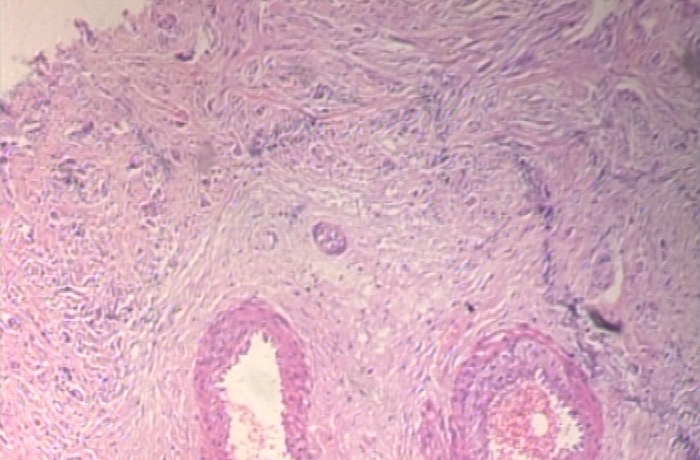

In [0]:
import matplotlib.pyplot as plt
from IPython.display import display

pathh = './drive/My Drive/Python 3/Training_SET/Mal/SOB_M_DC_14-10926/40X'

img = os.listdir(pathh)[4]
image_path = os.path.join(pathh,img)
image_obj = Image.open(image_path)
#pct = image_obj.rotate(180) 

display(image_obj)

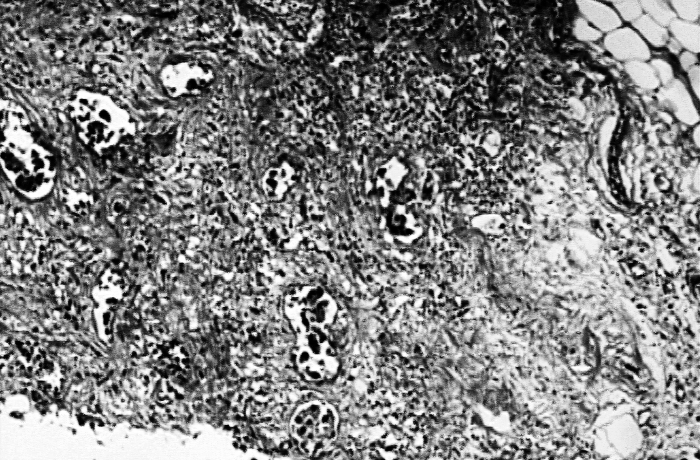

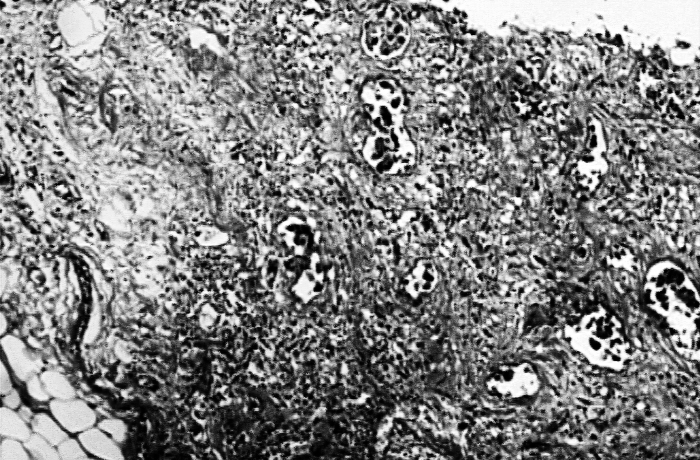

In [0]:
import matplotlib.pyplot as plt
from IPython.display import display

pathh = './drive/My Drive/Python 3/EH_40X/Training_EH_40X/Mal'

img = os.listdir(pathh)[10]
image_path = os.path.join(pathh,img)
image_obj = Image.open(image_path)
pct = image_obj.rotate(180) 

display(image_obj)
display(pct)

In [0]:
np.array(image_obj).shape

(460, 700)

## 5) Transfer Learning

These two major transfer learning scenarios look as follows:

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

These two major transfer learning scenarios look as follows:

  -  Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
  -  ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#### Loaders with Grayscale images
Let’s visualize a few training images so as to understand the data augmentations.

##### 5.1) *since the training/testing images can't fit on the memory, an image loader has to be used

In [0]:
# 40X This transformation is based upon ToTensor() & Normalization
# image sizes are (460, 700), so we use 10 torchvision.transforms.TenCrop(400) to make them square

import torchvision
import torchvision.transforms as tt 

TRANS = tt.Compose([ tt.TenCrop(400)  ,tt.Lambda(lambda crops: torch.stack([tt.ToTensor()(crop) for crop in crops])) ])
BATCHSIZE = 4

TR_FOLDER = './drive/My Drive/Python 3/EH_40X/Training_EH_40X'

TS_FOLDER = './drive/My Drive/Python 3/EH_40X/Testing_EH_40X'

set_tr = torchvision.datasets.ImageFolder(root=TR_FOLDER , transform=TRANS )

train_loader = torch.utils.data.DataLoader(set_tr, batch_size=BATCHSIZE, shuffle=True)

set_te = torchvision.datasets.ImageFolder(root=TS_FOLDER  , transform=TRANS )

test_loader = torch.utils.data.DataLoader(set_te, batch_size=BATCHSIZE)

class_names = set_tr.classes

#########################
image_datasets = {'train': set_tr, 'val': set_te }
dataloaders = {'train': train_loader, 'val': test_loader}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#########################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class_names

['Ben', 'Mal']

In [0]:
# 100X This transformation is based upon ToTensor() & Normalization

import torchvision
import torchvision.transforms as tt 

TR_FOLDER = './drive/My Drive/Python 3/EH_100X/Training_EH_100X'

TS_FOLDER = './drive/My Drive/Python 3/EH_100X/Testing_EH_100X'

set_tr = torchvision.datasets.ImageFolder(root=TR_FOLDER , transform=TRANS )

train_loader = torch.utils.data.DataLoader(set_tr, batch_size=BATCHSIZE, shuffle=True)

set_te = torchvision.datasets.ImageFolder(root=TS_FOLDER , transform=TRANS )

test_loader = torch.utils.data.DataLoader(set_te, batch_size=BATCHSIZE)

class_names = set_tr.classes

#########################
image_datasets = {'train': set_tr, 'val': set_te }
dataloaders = {'train': train_loader, 'val': test_loader}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#########################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# 200X This transformation is based upon ToTensor() & Normalization

import torchvision
import torchvision.transforms as tt 

TR_FOLDER = './drive/My Drive/Python 3/EH_200X/Training_EH_200X'

TS_FOLDER = './drive/My Drive/Python 3/EH_200X/Testing_EH_200X'

set_tr = torchvision.datasets.ImageFolder(root=TR_FOLDER , transform=TRANS )

train_loader = torch.utils.data.DataLoader(set_tr, batch_size=BATCHSIZE, shuffle=True)

set_te = torchvision.datasets.ImageFolder(root=TS_FOLDER , transform=TRANS )

test_loader = torch.utils.data.DataLoader(set_te, batch_size=BATCHSIZE)

class_names = set_tr.classes

#########################
image_datasets = {'train': set_tr, 'val': set_te }
dataloaders = {'train': train_loader, 'val': test_loader}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#########################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# 400X This transformation is based upon ToTensor() & Normalization

import torchvision
import torchvision.transforms as tt 

TR_FOLDER = './drive/My Drive/Python 3/EH_400X/Training_EH_400X'

TS_FOLDER = './drive/My Drive/Python 3/EH_400X/Testing_EH_400X'

set_tr = torchvision.datasets.ImageFolder(root=TR_FOLDER , transform=TRANS )

train_loader = torch.utils.data.DataLoader(set_tr, batch_size=TRANS, shuffle=True)

set_te = torchvision.datasets.ImageFolder(root=TS_FOLDER , transform=TRANS )

test_loader = torch.utils.data.DataLoader(set_te, batch_size=TRANS)

class_names = set_tr.classes

#########################
image_datasets = {'train': set_tr, 'val': set_te }
dataloaders = {'train': train_loader, 'val': test_loader}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#########################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Visualize a few grayscale images
Let’s visualize a few training images so as to understand the data augmentations.

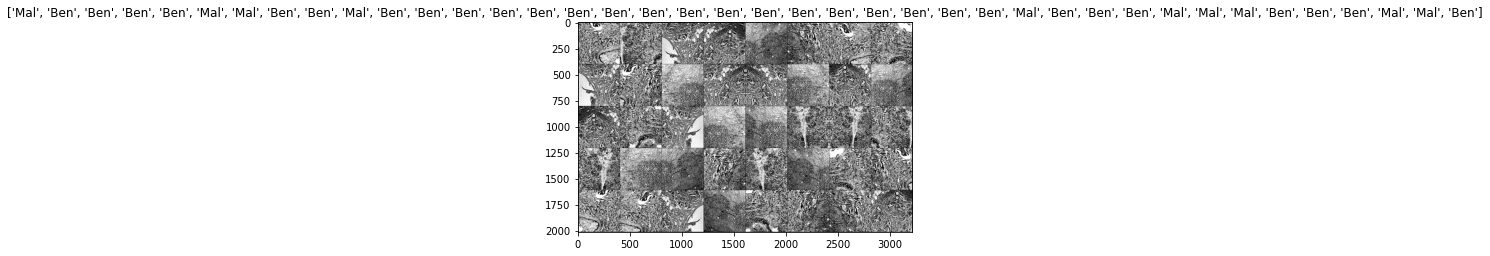

In [0]:
def imshoww(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # <--- To adjust the chanel dimension as the last channel
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs , classes = next(iter(train_loader))
#inputs = inputs.unsqueeze(0)
bs, ncrops, c, h, w = inputs.size()
inputs = inputs.view(-1, c, h, w) # fuse batch size and ncrops  
                # print([[ii.item()]*10 for ii in labels])
classes = (torch.tensor([[ii.item()]*10 for ii in classes]).flatten())
xx=torch.randperm(classes.size()[0])
classes = classes[xx]
inputs = inputs[xx,:,:,:] 

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

imshoww(out, title=[class_names[x] for x in classes])

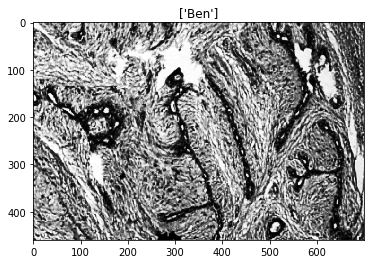

In [0]:
def imshoww(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs , classes = next(iter(train_loader))
#inputs = inputs.unsqueeze(0)
bs, ncrops, c, h, w = inputs.size()
inputs = inputs.view(-1, c, h, w) # fuse batch size and ncrops  
                # print([[ii.item()]*10 for ii in labels])
classes = (torch.tensor([[ii.item()]*10 for ii in classes]).flatten())
x=torch.randperm(classes.size()[0])
classes = classes[x]
inputs = inputs[x,:,:,:] 

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

imshoww(out, title=[class_names[x] for x in classes])

In [0]:
inputs.size()

torch.Size([1, 3, 460, 700])

In [0]:
def imshoww(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs , classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

imshoww(out, title=[class_names[x] for x in classes])

In [0]:
inputs.size()

torch.Size([32, 3, 460, 700])

Visualization with histogram equalizater in opencv

#### Training the model function

Now, let’s write a general function to train a model. Here, we will illustrate:

   -  Scheduling the learning rate
   -  Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

##### 5.2) *in the training/testing loop, each bach contains further crops of the image that should be reshaped into (N,3,400,400), also labels should be expanded by being multiplied by 10

In [0]:
# modified train_model function based on 10 crop image transformer

import time

def train_model(model, model_name, path, resolution,  criterion, optimizer, scheduler, num_epochs=25):
      since = time.time()

      MODEL_NAME = f"model-{model_name}-{resolution}-{int(time.time())}"

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0

      with open(os.path.join(path, MODEL_NAME+'.log'),'a') as f:  
        for epoch in tqdm(range(num_epochs)):
          
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            f.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
            f.write('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    
                    # import pdb; pdb.set_trace()

                    bs, ncrops, c, h, w = inputs.size()
                    inputs = inputs.view(-1, c, h, w) # fuse batch size and ncrops  
                    # print([[ii.item()]*10 for ii in labels])
                    labels = (torch.tensor([[ii.item()]*10 for ii in labels]).flatten())
                    # shuffle each batch further
                    xx=torch.randperm(labels.size()[0])
                    labels = labels[xx]
                    inputs = inputs[xx,:,:,:]

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        #print(outputs)
                        _ , preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    # import pdb; pdb.set_trace()

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / (10*dataset_sizes[phase])
                epoch_acc = running_corrects.double() / (10*dataset_sizes[phase])

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                f.write('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()
            f.write('')

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        f.write('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        f.write('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
      model.load_state_dict(best_model_wts)
      return model

### i) Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

##### resnet 34

In [0]:
model_ft = models.resnet34(pretrained=True)

In [0]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

###### Train and evaluate

In [0]:
model_name = 'Resnet-34'
path = './drive/My Drive/Python 3'
resolution = '40X'

model_ft_40 = train_model(model_ft, model_name, path, resolution, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15) 

In [0]:
torch.save(model_ft_40.state_dict(), '/content/Model_40')

In [0]:
from shutil import copyfile

copyfile('Model_40', 'drive/My Drive/Python 3/Model_Resnet-34_40X')

'drive/My Drive/Python 3/Model_Resnet-34_40X'

In [0]:
model_name = 'Resnet-34'
path = './drive/My Drive/Python 3'
resolution = '100X'

model_ft_100 = train_model_2(model_ft, model_name, path, resolution, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15) 

Epoch 0/14
----------
train Loss: 0.5926 Acc: 0.7153
val Loss: 0.4061 Acc: 0.8080

Epoch 1/14
----------
train Loss: 0.3993 Acc: 0.8336
val Loss: 0.3976 Acc: 0.8355

Epoch 2/14
----------
train Loss: 0.2863 Acc: 0.8806
val Loss: 0.2645 Acc: 0.8903

Epoch 3/14
----------
train Loss: 0.3012 Acc: 0.8766
val Loss: 0.3248 Acc: 0.8642

Epoch 4/14
----------
train Loss: 0.2311 Acc: 0.9072
val Loss: 0.5106 Acc: 0.8097

Epoch 5/14
----------
train Loss: 0.2252 Acc: 0.9082
val Loss: 0.2777 Acc: 0.8789

Epoch 6/14
----------
train Loss: 0.1660 Acc: 0.9389
val Loss: 1.1346 Acc: 0.6819

Epoch 7/14
----------
train Loss: 0.1106 Acc: 0.9581
val Loss: 0.3356 Acc: 0.8643

Epoch 8/14
----------
train Loss: 0.1157 Acc: 0.9569
val Loss: 0.3920 Acc: 0.8488

Epoch 9/14
----------
train Loss: 0.0881 Acc: 0.9691
val Loss: 0.3449 Acc: 0.8629

Epoch 10/14
----------
train Loss: 0.0610 Acc: 0.9804
val Loss: 0.3900 Acc: 0.8551

Epoch 11/14
----------
train Loss: 0.0977 Acc: 0.9646
val Loss: 0.3993 Acc: 0.8492

Ep

In [0]:
torch.save(model_ft_100.state_dict(), '/content/Model_100')

In [0]:
from shutil import copyfile

copyfile('Model_100', 'drive/My Drive/Python 3/Model_100_Res34')

'drive/My Drive/Python 3/Model_100_Res34'

In [0]:
model_ft_200 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.6177 Acc: 0.6892
val Loss: 0.4252 Acc: 0.8012

Epoch 1/14
----------
train Loss: 0.4164 Acc: 0.8199
val Loss: 0.3933 Acc: 0.8404

Epoch 2/14
----------
train Loss: 0.3223 Acc: 0.8665
val Loss: 0.4753 Acc: 0.8138

Epoch 3/14
----------
train Loss: 0.2726 Acc: 0.8927
val Loss: 0.3735 Acc: 0.8516

Epoch 4/14
----------
train Loss: 0.2975 Acc: 0.8817
val Loss: 0.5850 Acc: 0.8104

Epoch 5/14
----------
train Loss: 0.2532 Acc: 0.9054
val Loss: 0.4755 Acc: 0.8188

Epoch 6/14
----------
train Loss: 0.1734 Acc: 0.9317
val Loss: 0.3334 Acc: 0.8723

Epoch 7/14
----------
train Loss: 0.1145 Acc: 0.9568
val Loss: 0.3728 Acc: 0.8568

Epoch 8/14
----------
train Loss: 0.0913 Acc: 0.9672
val Loss: 0.3822 Acc: 0.8488

Epoch 9/14
----------
train Loss: 0.1168 Acc: 0.9543
val Loss: 0.3976 Acc: 0.8444

Epoch 10/14
----------
Epoch 0/14
----------
train Loss: 0.6177 Acc: 0.6892
val Loss: 0.4252 Acc: 0.8012

Epoch 1/14
----------
train Loss: 0.4164 Acc: 0.8199
val Loss: 0

In [0]:
torch.save(model_ft_200.state_dict(), '/content/Model_200')

In [0]:
from shutil import copyfile

copyfile('Model_200', 'drive/My Drive/Python 3/Model_200')

'drive/My Drive/Python 3/Model_200'

In [0]:
model_ft_400 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=13)

Epoch 0/12
----------
train Loss: 0.5781 Acc: 0.7173
val Loss: 0.3968 Acc: 0.8202

Epoch 1/12
----------
train Loss: 0.4441 Acc: 0.8031
val Loss: 0.4249 Acc: 0.8186

Epoch 2/12
----------
train Loss: 0.4099 Acc: 0.8287
val Loss: 0.5205 Acc: 0.7821

Epoch 3/12
----------
train Loss: 0.3021 Acc: 0.8777
val Loss: 0.6521 Acc: 0.7624

Epoch 4/12
----------
train Loss: 0.2228 Acc: 0.9141
val Loss: 0.5053 Acc: 0.7981

Epoch 5/12
----------
train Loss: 0.2334 Acc: 0.9089
val Loss: 0.5993 Acc: 0.7775

Epoch 6/12
----------
train Loss: 0.1969 Acc: 0.9248
val Loss: 0.3906 Acc: 0.8469

Epoch 7/12
----------
train Loss: 0.1073 Acc: 0.9600
val Loss: 0.4300 Acc: 0.8422

Epoch 8/12
----------
train Loss: 0.0851 Acc: 0.9678
val Loss: 0.4462 Acc: 0.8400

Epoch 9/12
----------
train Loss: 0.0954 Acc: 0.9651
val Loss: 0.4030 Acc: 0.8508

Epoch 10/12
----------
train Loss: 0.0835 Acc: 0.9685
val Loss: 0.3979 Acc: 0.8502

Epoch 11/12
----------
train Loss: 0.0975 Acc: 0.9649
val Loss: 0.4125 Acc: 0.8556

Ep

In [0]:
torch.save(model_ft_400.state_dict(), '/content/Model_400')

In [0]:
from shutil import copyfile

copyfile('Model_400', 'drive/My Drive/Python 3/Model_400')

'drive/My Drive/Python 3/Model_400'

### ii) Load saved model

What is a state_dict?

In PyTorch, the learnable parameters (i.e. weights and biases) of an torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers.

####    Evaluate & Visualize the model predictions

Generic function to display predictions for a few images

In [0]:
def imshoww(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training 
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
               
            bs, ncrops, c, h, w = inputs.size()
            inputs = inputs.view(-1, c, h, w) # fuse batch size and ncrops  
            # print([[ii.item()]*10 for ii in labels])
            labels = (torch.tensor([[ii.item()]*10 for ii in labels]).flatten())
            x=torch.randperm(labels.size()[0])
            labels = labels[x]
            inputs = inputs[x,:,:,:]

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images*10//5, 5, images_so_far)
                ax.axis('off')
                ax.set_title(f'label:{class_names[labels[j]]} , predicted: {class_names[preds[j]]}')
                imshoww(inputs.cpu().data[j])

                if images_so_far == num_images*10:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def evaluate_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
               
            bs, ncrops, c, h, w = inputs.size()
            inputs = inputs.view(-1, c, h, w) # fuse batch size and ncrops  
            # print([[ii.item()]*10 for ii in labels])
            labels = (torch.tensor([[ii.item()]*10 for ii in labels]).flatten())
            x=torch.randperm(labels.size()[0])
            labels = labels[x]
            inputs = inputs[x,:,:,:]

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images*10//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshoww(inputs.cpu().data[j])

                if images_so_far == num_images*10:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### resnet34

##### 5.3) *reloading the already trained model

In [0]:
####40X

model_ft_40 =  models.resnet34(pretrained=False)
num_ftrs = model_ft_40.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_40.fc = nn.Linear(num_ftrs, 2)

model_ft_40.load_state_dict(torch.load('drive/My Drive/Python 3/Model_40_Res34'))

model_ft_40 = model_ft_40.to(device)

model_ft_40.eval()

####100X

model_ft_100 =  models.resnet34(pretrained=False)
num_ftrs = model_ft_100.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_100.fc = nn.Linear(num_ftrs, 2)

model_ft_100.load_state_dict(torch.load('drive/My Drive/Python 3/Model_100_Res34'))

model_ft_100 = model_ft_100.to(device)

model_ft_100.eval()

####200X

model_ft_200 =  models.resnet34(pretrained=False)
num_ftrs = model_ft_200.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_200.fc = nn.Linear(num_ftrs, 2)

model_ft_200.load_state_dict(torch.load('drive/My Drive/Python 3/Model_200_Res34'))

model_ft_200 = model_ft_200.to(device)

model_ft_200.eval()

####400X

model_ft_400 =  models.resnet34(pretrained=False)
num_ftrs = model_ft_400.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_400.fc = nn.Linear(num_ftrs, 2)

model_ft_400.load_state_dict(torch.load('drive/My Drive/Python 3/Model_400_Res34'))

model_ft_400 = model_ft_400.to(device)

model_ft_400.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

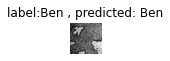

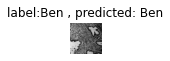

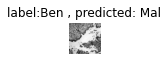

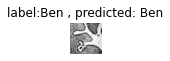

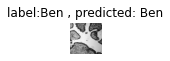

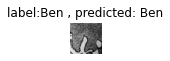

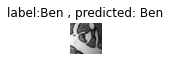

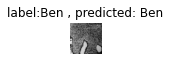

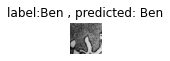

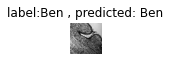

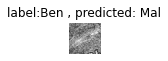

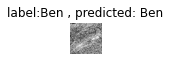

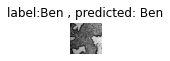

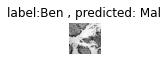

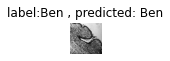

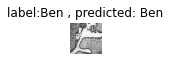

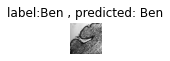

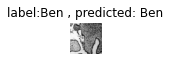

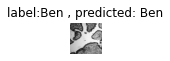

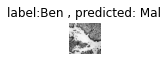

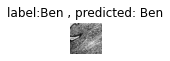

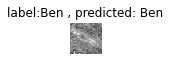

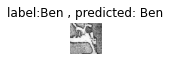

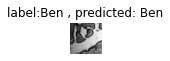

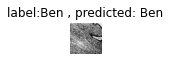

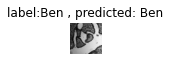

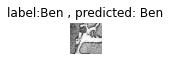

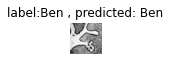

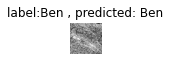

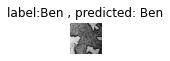

In [0]:
visualize_model(model_ft_40, test_loader, num_images=3)

### iii) ConvNet as fixed feature extractor



In [0]:
model_ft = models.resnet34(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                            nn.Dropout(p=0.45),
                            nn.ReLU(),
                            nn.Linear(256,2))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

##### 5.4) *using Resnet-34 as feature extractor does not work for histopathological images

In [0]:
model_name = 'Resnet-34-Fixed'
path = './drive/My Drive/Python 3'
resolution = '40X'

model_ft_40 = train_model(model_ft, model_name, path, resolution, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15) 

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7140 Acc: 0.4796
val Loss: 0.7051 Acc: 0.4691

Epoch 1/14
----------
train Loss: 0.7124 Acc: 0.4821
val Loss: 0.7102 Acc: 0.4419

Epoch 2/14
----------
train Loss: 0.7142 Acc: 0.4795
val Loss: 0.7057 Acc: 0.4672

Epoch 3/14
----------
train Loss: 0.7132 Acc: 0.4801
val Loss: 0.7061 Acc: 0.4679

Epoch 4/14
----------
train Loss: 0.7145 Acc: 0.4783
val Loss: 0.7060 Acc: 0.4694

Epoch 5/14
----------
train Loss: 0.7126 Acc: 0.4816
val Loss: 0.7053 Acc: 0.4652

Epoch 6/14
----------
train Loss: 0.7144 Acc: 0.4814
val Loss: 0.7096 Acc: 0.4446

Epoch 7/14
----------
train Loss: 0.7129 Acc: 0.4788
val Loss: 0.7027 Acc: 0.4800

Epoch 8/14
----------
train Loss: 0.7137 Acc: 0.4831
val Loss: 0.7045 Acc: 0.4757

Epoch 9/14
----------
train Loss: 0.7122 Acc: 0.4853
val Loss: 0.7051 Acc: 0.4673

Epoch 10/14
----------
train Loss: 0.7133 Acc: 0.4819
val Loss: 0.7059 Acc: 0.4624

Epoch 11/14
----------
train Loss: 0.7148 Acc: 0.4793
val Loss: 0.7064 Acc: 0.4690

Epoch 12/14
----------
